In [2]:
# local
import os
ROOT = os.path.abspath('')

In [3]:
%pip install transformers datasets

Note: you may need to restart the kernel to use updated packages.


In [42]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from transformers import RobertaForSequenceClassification, RobertaTokenizerFast
from torch.utils.data import Dataset

In [43]:
from torch import cuda
device = 'cuda:0' if cuda.is_available() else 'cpu'
device

'cuda:0'

Chargement données

In [44]:
train_df = pd.read_csv(os.path.join(ROOT, 'BUILD/train.csv'))
valid_df = pd.read_csv(os.path.join(ROOT, 'BUILD/dev.csv'))
test_df = pd.read_csv(os.path.join(ROOT, 'BUILD/test.csv'))

In [63]:
train_df

,doc_id,doc_index,sentence_index,annotation_id,text,meta_group,labels
0,1735,0,0,d7a902fe9c23417499a7ef782f9fbdeb,"IN THE HIGH COURT OF KARNATAKA,\n ...",Criminal,0
1,1735,0,1,8d41599e98424d9480c25109556a7d14,\n\n BEFORE\n\nTHE HON'BLE MR.JUSTICE ANA...,Criminal,0
2,1735,0,2,e501424117da40a7935c2d9f2fb2fe38,This Criminal Appeal is filed under Section 37...,Criminal,0
3,1735,0,3,4825806388fe43d39f73354b10b5b32d,\n\n This appeal coming on for hearing t...,Criminal,0
4,1735,0,4,d6893a25f82948f8be17fc9e876fb716,\n Heard the learned Counsel for the app...,Criminal,12
...,...,...,...,...,...,...,...
26082,4115,222,47,ed1047495bd141b787dc82f1c122171a,"As such, the High Court of Gujarath held that ...",Tax,6
26083,4115,222,48,79a753a82c5f4ea8a3c2ce0e241e15e9,"\n 10. The High Court of Madras, which was con...",Tax,6
26084,4115,222,49,803f5b29dc884254bfa84708ebb8cfb2,\n 11. The learned counsel for the appellant ...,Tax,6
26085,4115,222,50,04a8c49bbaff4061ae00f36d918650af,This Court concurs with the reasons assigned i...,Tax,10


In [45]:
rr_labels = [
    'PREAMBLE',
    'FAC',
    'RLC',
    'ISSUE',
    'ARG_PETITIONER',
    'ARG_RESPONDENT',
    'ANALYSIS',
    'STA',
    'PRE_RELIED',
    'PRE_NOT_RELIED',
    'RATIO',
    'RPC',
    'NONE'
]
MAP_LABEL = {k: i for i, k in enumerate(rr_labels)}
print(MAP_LABEL)

{'PREAMBLE': 0, 'FAC': 1, 'RLC': 2, 'ISSUE': 3, 'ARG_PETITIONER': 4, 'ARG_RESPONDENT': 5, 'ANALYSIS': 6, 'STA': 7, 'PRE_RELIED': 8, 'PRE_NOT_RELIED': 9, 'RATIO': 10, 'RPC': 11, 'NONE': 12}


In [46]:
train_df['labels']=train_df.labels.map(MAP_LABEL)
valid_df['labels']=valid_df.labels.map(MAP_LABEL)

<Axes: ylabel='count'>

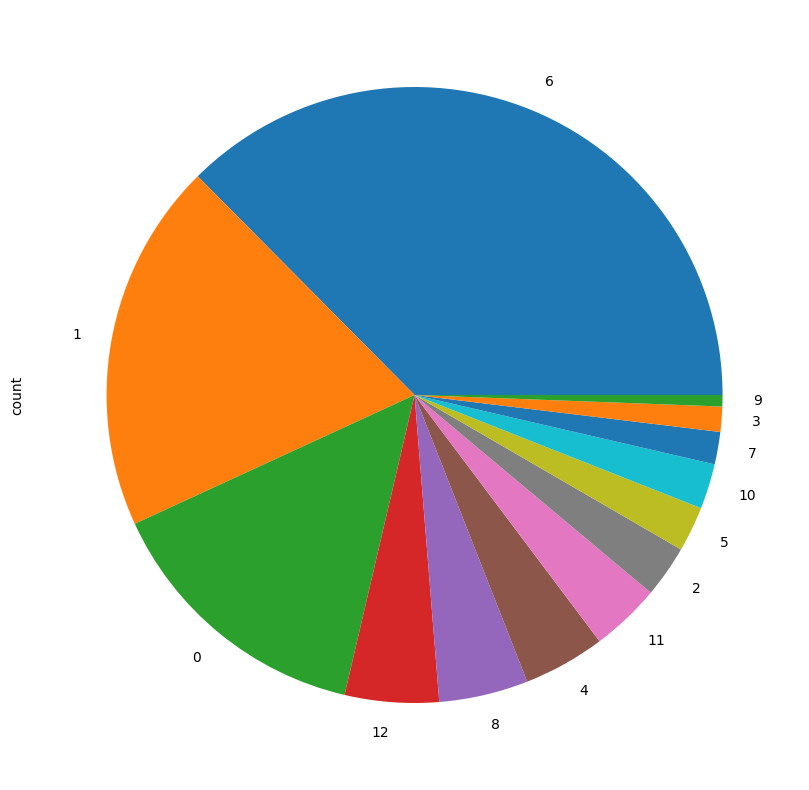

In [47]:
#train_df.labels.value_counts().plot(kind='pie', figsize=(10, 10))

Utilisation du modèle bert-base :

In [ ]:
#tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512)
#tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased",max_length=512)


In [ ]:
#model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=13)
#model.to(device)


Utilisation du modèle Legal-bert-base :

In [ ]:
# Charger le tokenizer Legal-BERT
#tokenizer = BertTokenizerFast.from_pretrained("nlpaueb/legal-bert-base-uncased", max_length=512)

# Charger le modèle Legal-BERT
#model = BertForSequenceClassification.from_pretrained("nlpaueb/legal-bert-base-uncased", num_labels=13)


Utilisation du modèle Roberta-base :

In [49]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base", max_length=512)

model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=13)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Réduction et echantillonage du dataset :

In [50]:
SIZE= train_df.shape[0]

In [51]:
print(SIZE)

26087


In [52]:
# Taille de l'échantillon que vous souhaitez
sample_size = 1000  # Par exemple, vous pouvez choisir 1000 pour un échantillon plus petit

# Échantillonnage des données d'entraînement
train_df_sample = train_df.sample(n=sample_size, random_state=42)

# Échantillonnage des données de validation 
val_df_sample = valid_df.sample(n=sample_size // 10, random_state=42)

# Sélection des textes et étiquettes d'entraînement et de validation
train_text = list(train_df_sample.text)
val_text = list(val_df_sample.text)

train_labels = list(train_df_sample.labels)
val_labels = list(val_df_sample.labels)


In [53]:
len(train_text), len(val_text), len(train_labels), len(val_labels)

(1000, 100, 1000, 100)

In [ ]:
# Création d'une classe personnalisée pour charger les données dans un format compatible avec PyTorch
train_encodings = tokenizer(train_text, truncation=True, padding=True)
val_encodings  = tokenizer(val_text, truncation=True, padding=True)


In [55]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)


In [56]:
# Création des objets DataLoader pour l'entraînement et la validation
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

Training avec Trainer Class

In [57]:
from transformers import TrainingArguments, Trainer

In [58]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.
    
    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of 
              that observation belonging to a certain class.
              
    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids
    
    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)
    
    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    
    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)
    
    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }


In [59]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./results', 
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0 
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,                
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory                 
    logging_dir='./multi-class-logs',            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps", 
    fp16=True,
    load_best_model_at_end=True
)

In [60]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned 
    model=model,
     # training arguments that we defined above                        
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=val_dataloader,            
    compute_metrics= compute_metrics
)

In [61]:
trainer.train()

  0%|          | 0/189 [00:00<?, ?it/s]

{'loss': 2.2922, 'learning_rate': 2.4e-05, 'epoch': 0.79}


  0%|          | 0/4 [00:00<?, ?it/s]

c:\Users\hugol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 2.1377930641174316, 'eval_Accuracy': 0.3, 'eval_F1': 0.04195804195804195, 'eval_Precision': 0.02727272727272727, 'eval_Recall': 0.09090909090909091, 'eval_runtime': 7.1856, 'eval_samples_per_second': 13.917, 'eval_steps_per_second': 0.557, 'epoch': 0.79}
{'loss': 1.7845, 'learning_rate': 4.9e-05, 'epoch': 1.59}


  0%|          | 0/4 [00:00<?, ?it/s]

c:\Users\hugol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.812593936920166, 'eval_Accuracy': 0.41, 'eval_F1': 0.14431468054094942, 'eval_Precision': 0.12134822804314331, 'eval_Recall': 0.18240778829014123, 'eval_runtime': 7.1357, 'eval_samples_per_second': 14.014, 'eval_steps_per_second': 0.561, 'epoch': 1.59}
{'loss': 1.4703, 'learning_rate': 2.303370786516854e-05, 'epoch': 2.38}


  0%|          | 0/4 [00:00<?, ?it/s]

c:\Users\hugol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.847049593925476, 'eval_Accuracy': 0.43, 'eval_F1': 0.18686775555667315, 'eval_Precision': 0.1657632222849614, 'eval_Recall': 0.23850267379679144, 'eval_runtime': 7.1532, 'eval_samples_per_second': 13.98, 'eval_steps_per_second': 0.559, 'epoch': 2.38}
{'train_runtime': 1733.4309, 'train_samples_per_second': 1.731, 'train_steps_per_second': 0.109, 'train_loss': 1.7331745611927496, 'epoch': 3.0}


TrainOutput(global_step=189, training_loss=1.7331745611927496, metrics={'train_runtime': 1733.4309, 'train_samples_per_second': 1.731, 'train_steps_per_second': 0.109, 'train_loss': 1.7331745611927496, 'epoch': 3.0})

In [62]:
# Evaluation du modèle sur l'ensemble de validation
q=[trainer.evaluate(eval_dataset=train_df) for train_df in [train_dataloader, val_dataloader]]

pd.DataFrame(q, index=["train","val"]).iloc[:,:5]

  0%|          | 0/32 [00:00<?, ?it/s]

c:\Users\hugol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/4 [00:00<?, ?it/s]

c:\Users\hugol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,1.027299,0.702,0.250308,0.247912,0.268096
val,1.689989,0.510,0.240847,0.217605,0.284670
